In [283]:
import os
import pprint
import pandas as pd
from bs4 import BeautifulSoup, NavigableString

# Functions

In [242]:
def parse_nested_braces(string):
    stack = []
    results = []
    current = []

    for char in string:
        if char == '{':
            stack.append('{')
            current.append(char)
        elif char == '}' and stack:
            stack.pop()
            current.append(char)
            if not stack:  # Completed a nested structure
                results.append(''.join(current))
                current = []
        elif stack:
            current.append(char)

    return results

In [243]:
def parse_key_value_pairs(string):
    def is_key_start(index):
        # Check if the current index is the start of a key
        return string[index] == '"' and (index == 0 or string[index - 1] not in '\\')

    def find_key_end(start_index):
        # Find the end of the key (next unescaped quote)
        index = start_index + 1
        while index < len(string):
            if string[index] == '"' and string[index - 1] != '\\':
                return index
            index += 1
        return -1

    def find_value(index):
        if string[index] in '{[':
            # Handle nested structure
            opening = string[index]
            closing = '}' if opening == '{' else ']'
            depth = 1
            index += 1
            while index < len(string) and depth > 0:
                if string[index] == opening:
                    depth += 1
                elif string[index] == closing:
                    depth -= 1
                index += 1
            return index
        else:
            # Handle simple value
            in_quotes = False
            while index < len(string):
                if string[index] == '"' and (index == 0 or string[index - 1] != '\\'):
                    in_quotes = not in_quotes
                elif not in_quotes and string[index] in ',}':
                    return index
                index += 1
            return index

    results = {}
    i = 0
    while i < len(string):
        if is_key_start(i):
            key_end = find_key_end(i)
            if key_end != -1:
                key = string[i + 1:key_end]
                # Skip to the colon and the following whitespace
                i = key_end + 2
                while i < len(string) and string[i] in ' \t':
                    i += 1
                value_end = find_value(i)
                value = string[i:value_end].strip()
                results[key] = value
                i = value_end
        i += 1

    return results

In [276]:
def parse_item(pageItem):
    if pageItem['type'] == '"TITLE"':
        new_pageItem['type'] = "TITLE"
        new_pageItem['value'] = pageItem['value']
        
    if pageItem['type'] == '"IMAGE"':
        new_pageItem['type'] = "IMAGE"
        userFile = parse_key_value_pairs(pageItem['userFile'])
        url = f"https://courses.edovo.com/{userFile['contentPath'][1:-1]}"
        new_pageItem['value'] = url

    if pageItem['type'] == '"SHORT_ANSWER"':
        new_pageItem['type'] = "SHORT_ANSWER"

        question = pageItem['value']
        question = ' '.join(BeautifulSoup(question, 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
        
        answers = [parse_key_value_pairs(pi) for pi in parse_nested_braces(pageItem['answers'][1:-1])]
        answers = answers[0]['answerText']
        
        html_soup = BeautifulSoup(answers, 'html.parser')

        all_text = []
        for tag in html_soup.stripped_strings:
            text = ' '.join(repr(tag).strip()[1:-1].replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
            all_text.append(text)
        
        new_pageItem['value'] = {'question': question, 'answers': all_text}

    if pageItem['type'] == '"TEXT"':
        new_pageItem['type'] = "TEXT"
        html = pageItem['value']
        html_soup = BeautifulSoup(html, 'html.parser')

        all_text = []
        for tag in html_soup.stripped_strings:
            text = ' '.join(repr(tag).strip()[1:-1].replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())
            all_text.append(text)

        html_imgs = html_soup.find_all('img')
        html_imgs_srcs = [img['src'].replace('\\"',"") for img in html_imgs if 'src' in img.attrs]
        
        new_pageItem['value'] = {'text': all_text, 'images': html_imgs_srcs}
        
    if pageItem['type'] == '"MULTIPLE_CHOICE"':
        new_pageItem['type'] = "MULTIPLE_CHOICE"

        question = pageItem['value']
        question = ' '.join(BeautifulSoup(question, 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())

        explanation = pageItem['explanation']
        explanation = ' '.join(BeautifulSoup(explanation, 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split())

        answers = [parse_key_value_pairs(pi) for pi in parse_nested_braces(pageItem['answers'][1:-1])] 
        answers = [(' '.join(BeautifulSoup(pi['answerText'], 'html.parser').text.replace("\n"," ").replace("\\\\\\", "").replace("\\", "").split()),pi['correct']) for pi in answers]

        new_pageItem['value'] = {'question': question, 'answers': answers, 'explanation': explanation}
        
    return new_pageItem

In [277]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

In [317]:
def extract_lesson(lesson_id):
    lesson_number = lesson_id.split('_')[1]  
    lesson_title = f"Lesson {lesson_number}" 
    
    row = df[df['lesson_name'].apply(lambda row: row.split(":")[0].strip()) == lesson_title]
    
    return row.values

# Read all files

In [318]:
df = pd.read_csv("csv_files/df_lessons_info_list.csv")
df.head()

,lesson_name,lesson_description
0,Lesson 1: Introduction to Web Development and...,"In this class, we'll dive into the basics of m..."
1,Lesson 2: Variables and Datatypes,"In this lesson, we will be reviewing Python da..."
2,Lesson 3: Strings and Lists,With a grasp of variables and datatypes under ...
3,"Lesson 4: Lists, Tuples, Dictionaries",In this lesson you'll delve into two new Pytho...
4,Lesson 5: Conditionals,asdf


In [319]:
root_path = '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/'
all_files = []

for root, dirs, files in os.walk(root_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file_path.endswith('.html'):
            all_files.append(file_path)
            
all_files.sort(key=natural_sort_key)
all_files

['/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_3.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_1/page_4.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_2/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_2/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_1.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_2.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_3.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_4.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_5.html',
 '/Users/vivianamarquez/Desktop/prisoneducation/raw_html/lesson_3/page_6.html',
 '/Users/vivianamarquez/Desktop/prisoned

▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼
 Lesson 1: Introduction to Web Development and Python
Info: 	 In this class, we'll dive into the basics of making websites and using Python, a computer language. We'll show you what it's all about, why it's important, and how Python can help. If you've ever thought about creating your own websites or apps, this is the perfect starting point!
▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲▲

*****************************************************************************************
lesson_1
page_1
*****************************************************************************************

►►► Item 1 | TITLE ◄◄◄

Welcome to Web Development!

►►► Item 2 | TEXT ◄◄◄


Welcome to Web Development!
Welcome to the world of web development! As you begin this journey, it's perfectly fine if you're new to the concept web development and the role of web developers. This cou
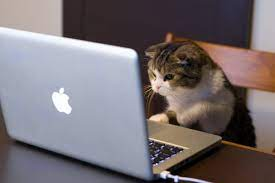


►►► Item 9 | TEXT ◄◄◄


MVC is almost used in every single app you’ve ever used!
MVC is a concept that is divided into 3 parts:
Model, View, and Controller!
MVC is just a tool to help us conceptualize how different parts of an app work together


*****************************************************************************************
lesson_11
page_4
*****************************************************************************************

►►► Item 1 | TITLE ◄◄◄

Knowledge Check

►►► Item 2 | MULTIPLE_CHOICE ◄◄◄

Question: 	 Which component of the MVC design pattern acts as the intermediary, coordinating interactions between the user interface and the data logic while also manipulating data?

• Model
• View
• Controller (CORRECT ANSWER)

Explanation: 	 In the MVC (Model-View-Controller) design pattern, the Controller serves as the intermediary between the Model and the View. It plays a crucial role in managing user interactions and updating the Model and View components accordingly. 


►►► Item 1 | TITLE ◄◄◄

Lesson #15: Databases pt. 1

►►► Item 2 | SHORT_ANSWER ◄◄◄

Question: 	 Warmup: # make an empty dictionary called user1 # add a username and a password to it # the keys should be ‘username’ and ‘password’ and values the corresponding values # add a bio, age, and zip code # bonus: how would you store multiple users?

Answers: 	 ['"', 'Your code might look something like this!', '#empty dict', 'user1 = {}', '#user + pass', "user1['username'] = 'myusername'", "user1['password'] = 'mypassword'", '#bio, age, zip code', "user1['bio'] = 'I love coding and learning new things!'", "user1['age'] = 25", "user1['zip_code'] = '12345'", '#bonus', 'users = []', "user2 = {n 'username': 'anotheruser',n 'password': 'anotherpassword',n 'bio': 'Exploring the world and enjoying life!',n 'age': 30,n 'zip_code': '67890'n}", 'users.append(user1)', 'users.append(user2)', '"']

►►► Item 3 | TITLE ◄◄◄

Review

►►► Item 4 | MULTIPLE_CHOICE ◄◄◄

Question: 	 Which HTTP method is typically u


►►► Item 3 | TEXT ◄◄◄


Since Python can only understand dictionaries… How do we turn JSONs into dictionaries?
JSON to Python - loads
JSON → Python dict
We use the
json
library to parse JSON strings to be able to interact with them, and then t
he
loads
function converts JSON
strings
to a python
dictionary
JSON to Python - dumps
Python dict → JSON
The
dumps
function works in the opposite direction and converts the a python
dictionary
to JSON
strings


Links to the images in the section:
https://lh6.googleusercontent.com/DGPn5u_hDi34u7Kmyfz3Gs8taFcsQTk3q470lNZwsZrLwxwnoMYmmcQbBn9oxMVKeulAwqRxLxkFKA2i9SMAKPM9N-vAqRDtk085ahcxNwnL5d2BGHt_Ngr6U_JG8bgWDNI-IfoA5A7gqie5UvT3b_g
https://lh4.googleusercontent.com/SD5eVLdsMD-GxTdH2Adwn9OwEeJfjRd66mo31-WaaeKTfjsFzT0NJhBgSZdTSE_7lZ37XM7QWTJvclIGQ7xWSmR_HYaK7BMww1ONjOXf3WHPVAGC8amUHKU7t5FUfwrzXGFSi5h8SDbj36IoNFncLD8

►►► Item 4 | TITLE ◄◄◄

Quick Check In

►►► Item 5 | TEXT ◄◄◄


APIs
are a way to use external content/code from other people and inclu

In [349]:
processed_lessons = set()
    
for path in all_files:
    lesson = path.split("/")[-2]
    page = path.split("/")[-1].split(".")[0]
    
    if lesson not in processed_lessons:
        ti_lesson = extract_lesson(lesson)
        print("▼"*89)
        print(ti_lesson[0][0])
        print(f"Info: \t {ti_lesson[0][1]}")
        print("▲"*89)
        print()
        processed_lessons.add(lesson)
    
    print("*"*89)
    print(lesson)
    print(page)
    print("*"*89)
    
    with open(path, 'r') as file:
        html_content = file.read()
        
    pageItems_string = html_content.split('"pageItems":[')[1].rsplit("]", maxsplit=1)[0]
    
    pageItems = parse_nested_braces(pageItems_string)
    pageItems = [parse_key_value_pairs(pi) for pi in pageItems]
    
    for i, pageItem in enumerate(pageItems):
        pi = parse_item(pageItem)
        print()
        print(f"►►► Item {i+1} | {pi['type']} ◄◄◄")
        print()
        
        if pi['type'] == 'TITLE':
            print(pi['value'][1:-1])
            
        if pi['type'] == 'TEXT':
            for text in pi['value']['text']:
                if text == '"' or text =="nn":
                    print()
                else:
                    print(text)
            if 'images' in pi['value'].keys():
                if len(pi['value']['images'])>0:
                    print()
                    print("Links to the images in the section:")
                    for image in pi['value']['images']:
                        print(image)
                        
        if pi['type'] == 'MULTIPLE_CHOICE':
            print(f"Question: \t {pi['value']['question'][1:-1].strip()}")
            print()
            for answer in pi['value']['answers']:
                if answer[1] == 'true':
                    print(f"• {answer[0][1:-1].strip()} (CORRECT ANSWER)")
                else:
                    print(f"• {answer[0][1:-1].strip()}")
            print()    
            print(f"Explanation: \t {pi['value']['explanation'][1:-1].strip()}")
            
        if pi['type'] == 'SHORT_ANSWER':
            print(f"Question: \t {pi['value']['question'][1:-1].strip()}")
            print()
            print(f"Answers: \t {pi['value']['answers']}")
            
        if pi['type'] == 'IMAGE':
            print(pi['value'])
        
    print()
    